In [2]:
import numpy as np
import pandas as pd
import scipy as sp
import yfinance as yf
import pypfopt 
import matplotlib.pyplot as plt

from pypfopt import black_litterman, plotting, objective_functions, risk_models
from pypfopt import BlackLittermanModel
from pypfopt.efficient_frontier import EfficientFrontier

In [3]:
tickers = ["TSLA", "NVDA", "AMZN", "META", "RIVN", "INTC", "AMD"]

start_date = '2013-01-01'
end_date = '2024-01-01'

In [4]:
data = yf.download(tickers, start=start_date, end=end_date)
data.to_csv("./Data/historical_data.csv")

closing_prices = data["Adj Close"]
returns = np.log(closing_prices / closing_prices.shift(1).dropna())

def get_market_prices_and_caps(tickers, start_date, end_date):
    market_prices = yf.download("VOO", start=start_date, end=end_date)["Adj Close"]

    market_caps = {}
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        market_caps[ticker] = stock.info.get("marketCap", None)

    return market_prices, market_caps

closing_prices.tail(10)

[*********************100%***********************]  7 of 7 completed


Ticker,AMD,AMZN,INTC,META,NVDA,RIVN,TSLA
Date,,,,,,,
2023-12-15 00:00:00+00:00,139.149994,149.970001,45.549953,333.914612,48.876141,22.830000,253.500000
2023-12-18 00:00:00+00:00,138.899994,154.070007,45.086170,343.585510,50.062805,23.799999,252.080002
2023-12-19 00:00:00+00:00,140.149994,153.789993,46.043346,349.308289,49.589939,24.350000,257.220001
2023-12-20 00:00:00+00:00,135.470001,152.119995,45.155243,348.231506,48.097359,23.180000,247.139999
2023-12-21 00:00:00+00:00,139.910004,153.839996,46.457802,353.027069,48.976116,23.580000,254.500000
2023-12-22 00:00:00+00:00,139.600006,153.419998,47.365639,352.329193,48.816162,23.209999,252.539993
2023-12-26 00:00:00+00:00,143.410004,153.410004,49.832600,353.764862,49.265030,23.590000,256.609985
2023-12-27 00:00:00+00:00,146.070007,153.339996,50.089161,356.755829,49.402992,23.730000,261.440002
2023-12-28 00:00:00+00:00,148.759995,153.380005,49.724052,357.244354,49.507965,23.540001,253.179993


<Axes: >

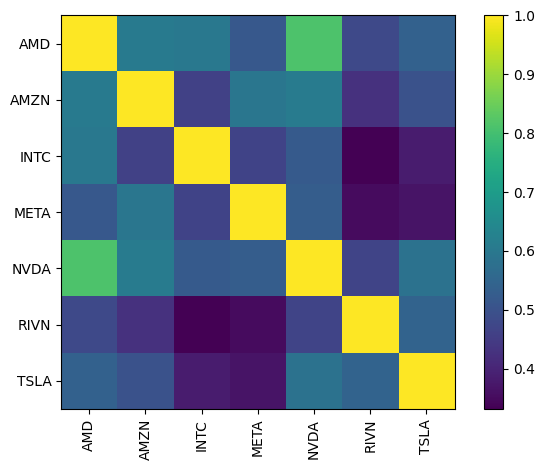

In [5]:
fg_covariance_matrix = returns.cov()
plotting.plot_covariance(fg_covariance_matrix, plot_correlation=True)

In [6]:
market_prices, market_caps = get_market_prices_and_caps(tickers, start_date, end_date)
delta = black_litterman.market_implied_risk_aversion(market_prices)
prior = black_litterman.market_implied_prior_returns(market_caps, delta, fg_covariance_matrix)

market_caps
market_prices

[*********************100%***********************]  1 of 1 completed


Date
2013-01-02    108.388969
2013-01-03    108.291565
2013-01-04    108.745926
2013-01-07    108.453857
2013-01-08    108.129333
                 ...    
2023-12-22    431.015472
2023-12-26    432.807709
2023-12-27    433.599854
2023-12-28    433.669128
2023-12-29    432.510620
Name: Adj Close, Length: 2768, dtype: float64

### Get Individual Fear-Greed Score

In [ ]:
def get_fear_greed(tickers, start_date='2023-01-01', end_date='2024-01-01'):
    fear_greed_scores_dict = {}

    for ticker in tickers:
        try:
            # calculate each indicator for the stock
            rsi = calculate_stock_rsi([ticker], start_date=start_date, end_date=end_date)[ticker].iloc[-1]['RSI']
            price_strength, high, low, current_price = calculate_stock_price_strength([ticker])
            breadth_data = calculate_stock_price_breadth([ticker], start=start_date, end=end_date)
            volatility = calculate_market_volatility([ticker], start_date=start_date, end_date=end_date)[ticker]
            put_call_ratio = calculate_put_call_ratio([ticker])[ticker]

            # normalise each indicator (as rsi is from 0-100 etc)
            normalised_rsi = rsi / 100
            normalised_price_strength = price_strength
            latest_breadth_ratio = breadth_data['breadth_ratio'].iloc[-1]
            normalised_breadth = min(max(latest_breadth_ratio / 2, 0), 1)
            normalised_volatility = min(max(volatility / 100, 0), 1)
            normalised_put_call_ratio = min(max(put_call_ratio, 0), 1) if put_call_ratio is not None else 0.5

            # weights for each indicator - these are arbitrary values
            # rsi_weight = 0.4
            # price_strength_weight = 0.2
            # breadth_weight = 0.2
            # volatility_weight = 0.2
            # put_call_ratio_weight = 0.1

            rsi_weight = 0.2 #  ewqual weights
            price_strength_weight = 0.2
            breadth_weight = 0.2
            volatility_weight = 0.2
            put_call_ratio_weight = 0.2

            # calculate the FG score
            fear_greed_score = (
                normalised_rsi * rsi_weight +
                normalised_price_strength * price_strength_weight +
                normalised_breadth * breadth_weight +
                normalised_volatility * volatility_weight +
                normalised_put_call_ratio * put_call_ratio_weight
            )

            fear_greed_scores_dict[ticker] = fear_greed_score

        except Exception as error:
            print(f"An error has occurred for {ticker}: {error} when attempting to calculate the fear-greed score")
            fear_greed_scores_dict[ticker] = None

    return fear_greed_scores_dict

def calculate_stock_rsi(tickers, period=14, start_date="2023-01-01", end_date="2024-01-01"):
    rsi_dict = {}
    
    for ticker in tickers:
        try:
            stock_data = yf.download(ticker, start=start_date, end=end_date)
            stock_data['Change'] = stock_data['Close'].diff()
            stock_data['Gain'] = np.where(stock_data['Change'] > 0, stock_data['Change'], 0)
            stock_data['Loss'] = np.where(stock_data['Change'] < 0, -stock_data['Change'], 0)

            stock_data['Avg_Gain'] = stock_data['Gain'].rolling(window=period, min_periods=1).mean()
            stock_data['Avg_Loss'] = stock_data['Loss'].rolling(window=period, min_periods=1).mean()

            stock_data['RS'] = stock_data['Avg_Gain'] / stock_data['Avg_Loss']
            stock_data['RSI'] = 100 - (100 / (1 + stock_data['RS']))

            rsi_dict[ticker] = stock_data[['Close', 'RSI']].dropna()
            
        except Exception as error:
            print(f"An error occurred for {ticker}: {error} when calculating RSI")
            rsi_dict[ticker] = None
    
    return rsi_dict

def calculate_stock_price_strength(tickers):
    for ticker in tickers:
        try:
            stock_data = yf.Ticker(ticker)
            stock_history = stock_data.history(period="1y")

            high = stock_history['Close'].max()
            low = stock_history['Close'].min()
            current_price = stock_history['Close'].iloc[-1]

            proximity_to_high = (current_price - low) / (high - low)
        except Exception as error:
            print(f"An error occurred for {ticker}: {error} when calculating price strength")
            proximity_to_high = high = low = current_price = None
        
    return proximity_to_high, high, low, current_price

def calculate_stock_price_breadth(tickers, start, end):
    all_results = pd.DataFrame()

    for ticker in tickers:
        try:
            data = yf.download(ticker, start=start, end=end)
            close_data = data['Close']
            volume_data = data['Volume']

            price_change = close_data.pct_change().fillna(0)
            results = pd.DataFrame(index=close_data.index)

            results['rising_volume'] = np.where(price_change > 0, volume_data, 0)
            results['declining_volume'] = np.where(price_change < 0, volume_data, 0)

            results['breadth_ratio'] = results['rising_volume'].sum() / results['declining_volume'].sum()
            results['ticker'] = ticker

            all_results = pd.concat([all_results, results])
        except Exception as error:
            print(f"An error occurred for {ticker}: {error} when calculating price breadth")

    return all_results

def calculate_market_volatility(tickers, start_date='2023-01-01', end_date='2024-01-01'):
    volatility_dict = {}
    
    for ticker in tickers:
        try:
            stock_data = yf.download(ticker, start=start_date, end=end_date)
            stock_data['Returns'] = stock_data['Close'].pct_change()
            stock_data['Volatility'] = stock_data['Returns'].rolling(window=50).std() * np.sqrt(252)
            
            latest_volatility = stock_data['Volatility'].iloc[-1]
            volatility_dict[ticker] = latest_volatility
        except Exception as error:
            print(f"An error occurred for {ticker}: {error} when calculating volatility")
            volatility_dict[ticker] = None
    
    return volatility_dict

def calculate_put_call_ratio(tickers):
    put_call_ratios = {}
    
    for ticker in tickers:
        try:
            options = yf.Ticker(ticker).option_chain()
            puts = options.puts
            calls = options.calls
            
            total_put_volume = puts['volume'].sum()
            total_call_volume = calls['volume'].sum()
            put_call_ratio = total_put_volume / total_call_volume if total_call_volume != 0 else None
            put_call_ratios[ticker] = put_call_ratio
            
        except Exception as error:
            print(f"An error occurred for {ticker}: {error} when calculating put call ratio")
            put_call_ratios[ticker] = None
    
    return put_call_ratios

fear_greed_scores = get_fear_greed(tickers, start_date, end_date)
print(fear_greed_scores) # 0-1, higher score is greedier

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

{'TSLA': 0.5224888924743056, 'NVDA': 0.5181614101059977, 'AMZN': 0.5375058872005799, 'META': 0.5148328000673652, 'RIVN': 0.46669032342809985, 'INTC': 0.3790755447009632, 'AMD': 0.446555059545509}


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


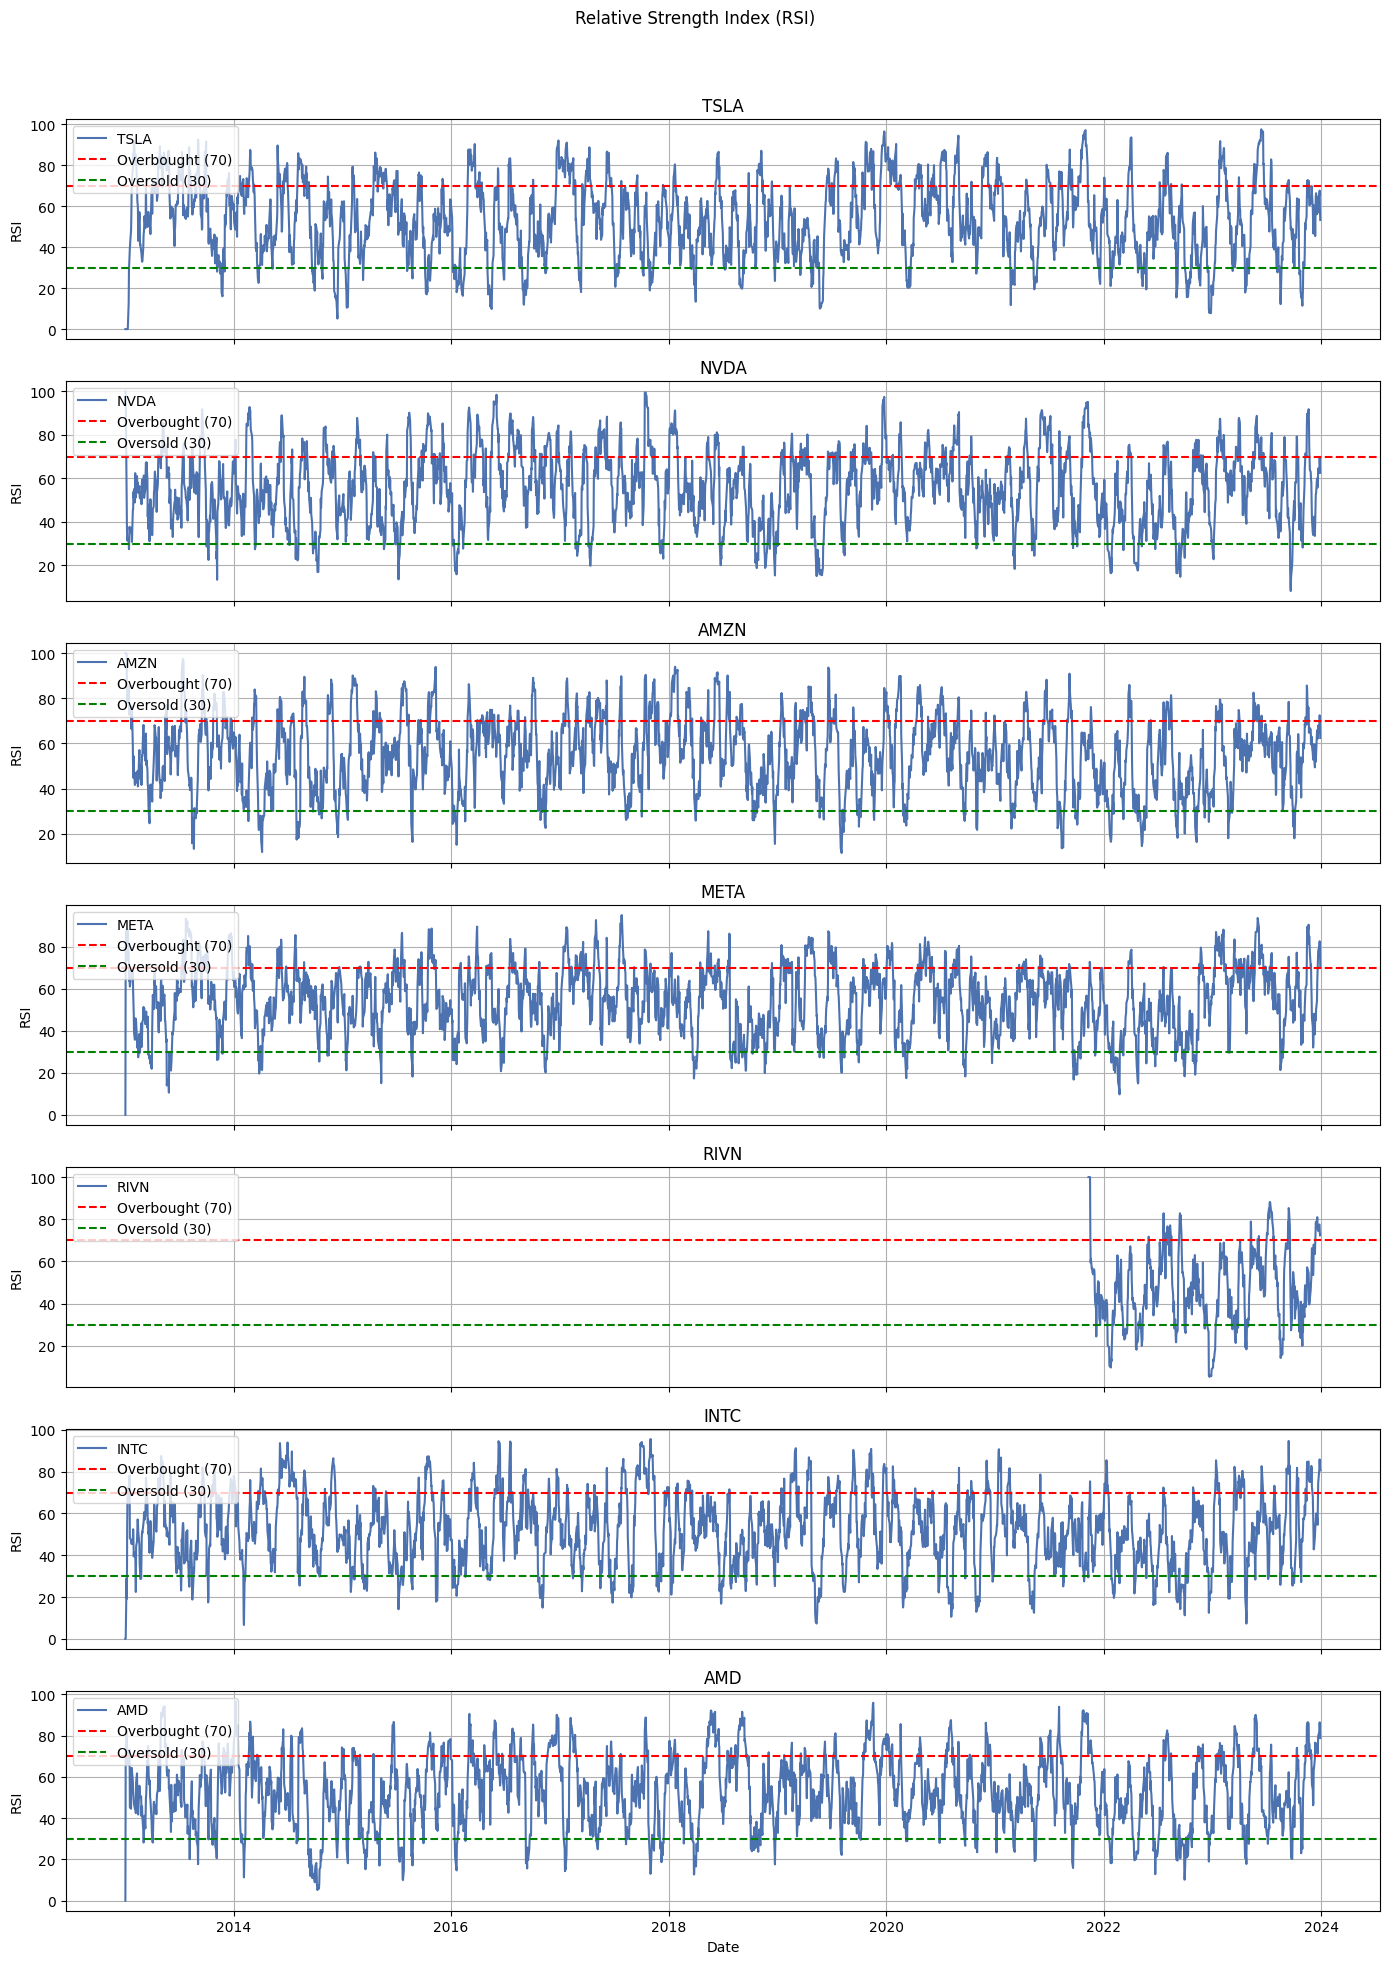

In [9]:
rsi = calculate_stock_rsi(tickers, start_date=start_date, end_date=end_date)

def plot_stock_rsi(ticker: str, start_date: str = "2023-01-01", end_date: str = "2024-01-01"):
    fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(14, 20), sharex=True)
    fig.suptitle('Relative Strength Index (RSI)')

    for ax, ticker in zip(axes, tickers):
        ax.plot(rsi[ticker].index, rsi[ticker]['RSI'], label=ticker)
        ax.axhline(70, color='red', linestyle='--', label='Overbought (70)')
        ax.axhline(30, color='green', linestyle='--', label='Oversold (30)')
        ax.set_title(ticker)
        ax.set_ylabel('RSI')
        ax.legend(loc='upper left')
        ax.grid(True)

    axes[-1].set_xlabel('Date')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def plot_stock_price_strength(tickers: list):
    fig, axes = plt.subplots(nrows=len(tickers), ncols=1, figsize=(14, 20), sharex=True)
    fig.suptitle('Stock Price Strength')

    for ax, ticker in zip(axes, tickers):
        proximity_to_high, high, low, current_price = calculate_stock_price_strength(ticker)

        stock_data = yf.Ticker(ticker)
        stock_history = stock_data.history(period="1y")

        ax.plot(stock_history.index, stock_history['Close'], label='Close price', color='blue')
        ax.axhline(high, color='red', linestyle='--', label='52 week high')
        ax.axhline(low, color='green', linestyle='--', label='52 week low')
        ax.scatter(stock_history.index[-1], current_price, color='purple', label=f'Current Price (Proximity: {proximity_to_high:.2f})')

        ax.set_title(ticker)
        ax.set_ylabel('Price')
        ax.legend(loc='upper left')
        ax.grid(True)

    axes[-1].set_xlabel('Date')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def plot_stock_price_breadth(tickers: list):
    fig, axes = plt.subplots(nrows=len(tickers), ncols=1, figsize=(14, 20), sharex=True)
    fig.suptitle('Stock Price Breadth')

    for ax, ticker in zip(axes, tickers):
        breadth_data = calculate_stock_price_breadth(ticker, start=start_date, end=end_date)
        ax.plot(breadth_data.index, breadth_data['breadth_ratio'], label=ticker)
        ax.axhline(1, color='red', linestyle='--', label='Neutral (1)')
        ax.set_title(ticker)
        ax.set_ylabel('Breadth Ratio')
        ax.legend(loc='upper left')
        ax.grid(True)

    axes[-1].set_xlabel('Date')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def plot_market_volatility(tickers, start_date='2023-01-01', end_date='2024-01-01'):
    volatility_data = calculate_market_volatility(tickers, start_date, end_date)
    
    plt.figure(figsize=(10, 6))
    for ticker in tickers:
        plt.plot(volatility_data[ticker], label=ticker)
    
    plt.title('Market Volatility')
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.legend()
    plt.show()

def plot_put_call_ratio(tickers: list):
    fig, axes = plt.subplots(nrows=len(tickers), ncols=1, figsize=(14, 20), sharex=True)
    fig.suptitle('Put Call Ratio')

    for ax, ticker in zip(axes, tickers):
        put_call_data = calculate_put_call_ratio([ticker])
        ax.plot(put_call_data[ticker].index, put_call_data[ticker], label=ticker)
        ax.axhline(1, color='red', linestyle='--', label='Neutral (1)')
        ax.set_title(ticker)
        ax.set_ylabel('Put Call Ratio')
        ax.legend(loc='upper left')
        ax.grid(True)

    axes[-1].set_xlabel('Date')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

plot_stock_rsi(tickers) # working
# plot_stock_price_strength(tickers) # not working
# plot_stock_price_breadth(tickers) # not plotting correctly
# plot_market_volatility(tickers, start_date='2023-01-01', end_date='2024-01-01') # no data
# plot_put_call_ratio(tickers) # not working

In [10]:
views = {ticker: score for ticker, score in fear_greed_scores.items()}
print(views)

{'TSLA': 0.5224888924743056, 'NVDA': 0.5181614101059977, 'AMZN': 0.5375058872005799, 'META': 0.5148328000673652, 'RIVN': 0.46669032342809985, 'INTC': 0.3790755447009632, 'AMD': 0.446555059545509}


### Convert to Views

In [11]:
bullish_threshold = 0.50 # this should ideally be 70+
bearish_threshold = 0.3

fg_based_views = {}
fg_based_confidences = {}

for ticker, score in fear_greed_scores.items():
    if score > bullish_threshold:
        view_returns = 0.02 + (score - bullish_threshold) * 0.0001
    elif score < bearish_threshold:
        view_returns = -0.02 + (bearish_threshold - score) * 0.0001
    else:
        view_returns = 0.0

    fg_based_views[ticker] = view_returns
    confidence = abs(score - 0.5) / 0.5
    fg_based_confidences[ticker] = confidence

print(f"views: {fg_based_views}")
print(f"confidences: {fg_based_confidences}")

views: {'TSLA': 0.02000224888924743, 'NVDA': 0.0200018161410106, 'AMZN': 0.02000375058872006, 'META': 0.020001483280006737, 'RIVN': 0.0, 'INTC': 0.0, 'AMD': 0.0}
confidences: {'TSLA': 0.044977784948611266, 'NVDA': 0.0363228202119954, 'AMZN': 0.0750117744011598, 'META': 0.029665600134730408, 'RIVN': 0.0666193531438003, 'INTC': 0.24184891059807356, 'AMD': 0.106889880908982}


In [ ]:
views_vs_scores = pd.DataFrame([fear_greed_scores, fg_based_views, fg_based_confidences], index=["Fear-Greed Scores", "Views", "Confidences"]).T
views_vs_scores

,Fear-Greed Scores,Views,Confidences
TSLA,0.522489,0.020002,0.044978
NVDA,0.518161,0.020002,0.036323
AMZN,0.537506,0.020004,0.075012
META,0.514833,0.020001,0.029666
RIVN,0.466690,0.000000,0.066619
INTC,0.379076,0.000000,0.241849
AMD,0.446555,0.000000,0.106890


In [ ]:
fear_greed_bl = BlackLittermanModel(
    fg_covariance_matrix, 
    pi=prior, 
    absolute_views=fg_based_views, # convert fg_based_views to relative views
    relative_views=None,
    P=None,
    omega="Idzorek", # need to change this to Idzorek
    view_confidences=fg_based_confidences, # also need to convert to array (and probs need to change the length to match dimensions of views array)
    tau=0.025,
    risk_aversion=delta
)

fear_greed_returns = fear_greed_bl.bl_returns()
fear_greed_returns

TypeError: self.omega must be a square array, dataframe, or string

<Axes: >

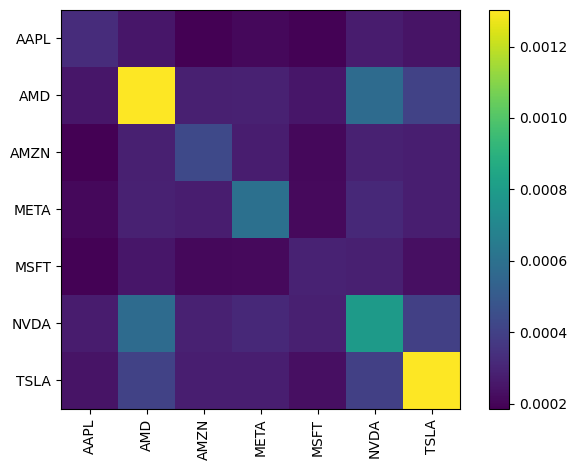

In [121]:
fg_posterior_cov = fear_greed_bl.bl_cov()
plotting.plot_covariance(fg_posterior_cov)

In [122]:
fg_ef = EfficientFrontier(fear_greed_returns, fg_posterior_cov)
# min_vol_weights = ef.min_volatility() # max_sharpe not working. look into this
fg_weights = fg_ef.min_volatility()

cleaned_weights = fg_ef.clean_weights()
cleaned_weights

OrderedDict([('AAPL', 0.3542),
             ('AMD', 0.0),
             ('AMZN', 0.16226),
             ('META', 0.04388),
             ('MSFT', 0.43967),
             ('NVDA', 0.0),
             ('TSLA', 0.0)])

In [123]:
fg_ef.portfolio_performance(verbose=True)

Expected annual return: 0.9%
Annual volatility: 1.5%
Sharpe Ratio: -0.73


(0.008658083537870708, 0.015448148302337096, -0.7341926190864838)